# Example of how to use SMO_ES algorithm to train SVMs

## Initialization

In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from SMO_ES import SMO_ES

## Generate a synthetic dataset

In [2]:
def gen_data(n, d, normalized = False, rs=37, cs = 4.0, flip = 0.00, test_size = 0.2, val_size = 0.1):
    
    # Generate a synthetic dataset
    X, y = make_classification(
        n_samples=n, 
        n_features=d, 
        n_informative=d, 
        n_redundant=0, 
        n_clusters_per_class=1, 
        class_sep= cs, 
        random_state= rs,
        flip_y= flip)
    y = np.where(y == 0, -1, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rs)    
    X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=val_size, random_state=rs, stratify=y_test)
    
    if normalized:
        scalar = MinMaxScaler()
        scalar.fit(X_train)
        X_train = scalar.transform(X_train)
        X_test = scalar.transform(X_test)  
        X_val = scalar.transform(X_val)      
        
    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
# Create a synthetic dataset
X_train, X_val, X_test, y_train, y_val, y_test = gen_data(
    n = 1000,
    d = 2,
    normalized = True,
    rs= 8,
    cs = 1.0,
    flip = 0.2,
    test_size = 0.2,
    val_size = 0.1
)

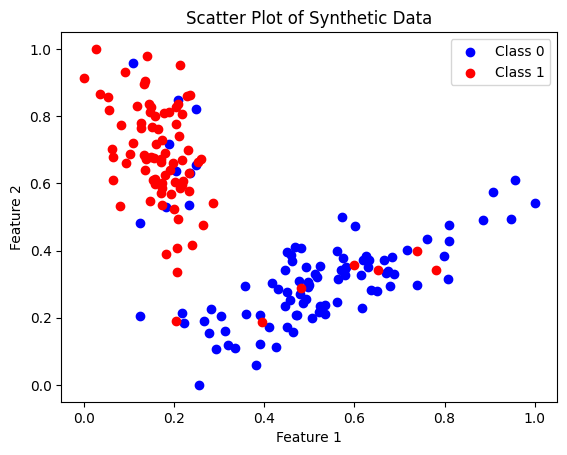

In [4]:
# Separate the data points by class
class_0 = X_train[y_train == -1]
class_1 = X_train[y_train == 1]

# Plot the data points
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', label='Class 1')

# Add labels and legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Synthetic Data')
plt.legend()

# Show the plot
plt.show()

## Train SVM

In [8]:
# Initialize SVM object, setting the hyperparameters
mod = SMO_ES(
    # SVM model hyperparameters
    c = 100.0,         
    tolerance = 1e-3,
    kernel = 'rbf', 
    
    # ES hyperparameters     
    early_stop = True,
    es_objective = 'hinge',
    patience = 5,
    es_tolerance = 0.0001,
    r = 1,
             
    log_objectives = True,
    time_lim = None # We do not set a time limit since it is a toy example
)

# Train the model, note, how we need to assign validation datasets.
mod.fit(
    X = X_train,
    y = y_train,
    X_val = X_val,
    y_val = y_val
)


0.6924223459478405 -0.0001 True
0.8934266797090729 -0.0001 True
0.9919252818706557 -0.0001 True
0.4464447482519935 -0.0001 True
0.39147279229774823 -0.0001 True
Training Stopped Early


## Visualize model

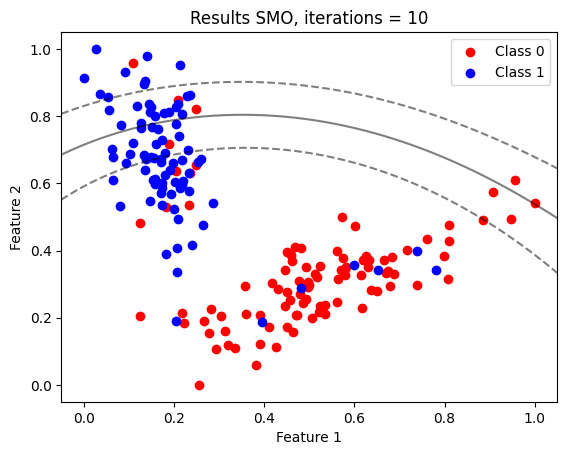

In [6]:
# Visualize the resulting SVM on the training data.
# Note: this code only works if the dataset has a dimensionality of 2

X = X_train
y = y_train

plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='red', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')

# Plot the decision boundary and margins
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
input = np.array([xx.ravel(), yy.ravel()]).T

pred_array = np.zeros(input.shape[0])
pred_array = mod.predict(input)[1]

pred_array = pred_array.reshape(xx.shape)

# Plot decision boundary and margins
ax.contour(xx, yy, pred_array, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])


# Add labels and a legend
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("Results SMO, iterations = {0}".format(mod.iters))
plt.legend()


# Show the plot
plt.show()

## Plot training curves 

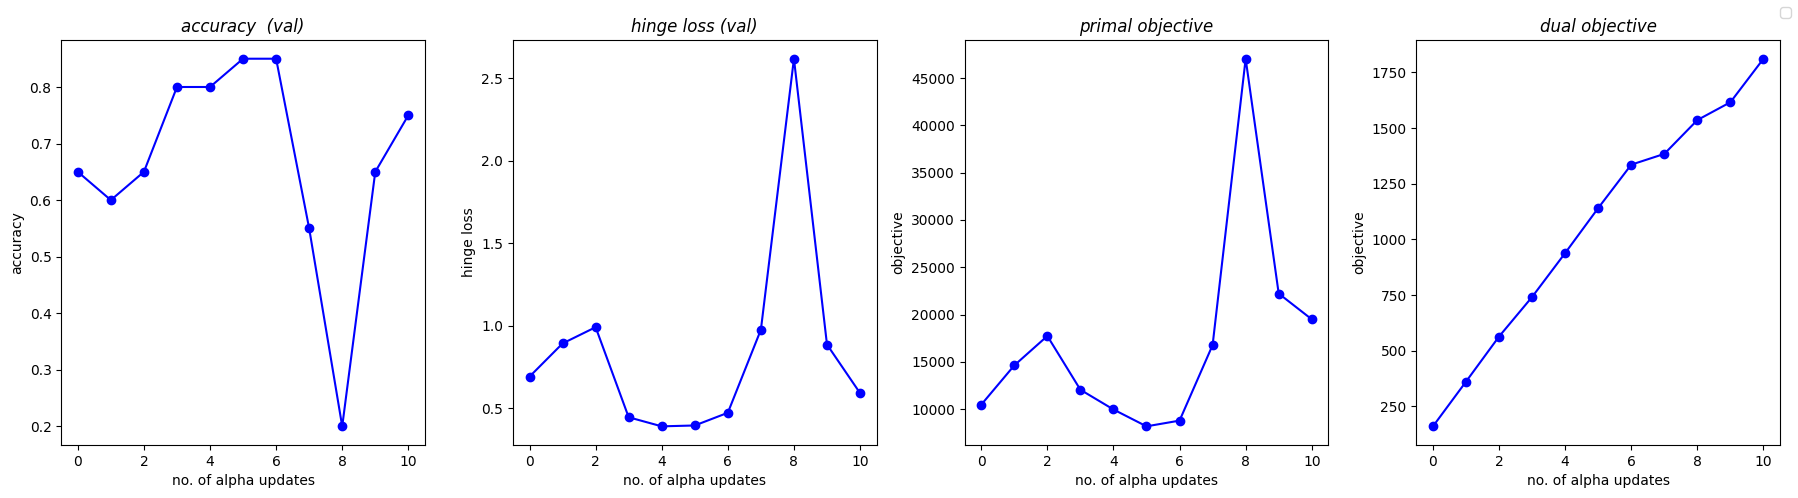

In [7]:
# Retrieve the data of the objectives (only available if logging_enabled = True)
objective_data = (mod.intermediate_acc, mod.intermediate_hinge, mod.intermediate_prim, mod.intermediate_dual)

figure, axis = plt.subplots(1,len(objective_data), figsize=(18, 5)) 
y_labels = ['accuracy', 'hinge loss', 'objective', 'objective']
x_labels = ['no. of alpha updates']
titles = ['accuracy  (val)', 'hinge loss (val)', 'primal objective', 'dual objective']

# Loop over the different objectives
for index, data in enumerate(objective_data):
    
    # create array with alpha update samples
    samples = list(range(len(data)))
    samples = list(map(lambda x: x * mod.r, samples)) # correction when applying a reduced ES frequency set with r

    # Plot objectives
    axis[index].plot(samples, data, marker='o', linestyle='-', color='b')
    
    # Add labels and title
    axis[index].set_xlabel(x_labels[0])
    axis[index].set_ylabel('{0}'.format(y_labels[index]))
    axis[index].set_title('{0}'.format(titles[index]),
                    fontstyle='italic')
    
    # Plot figure title and legend
    handles, labels = axis[index].get_legend_handles_labels()          

figure.legend(handles, labels)

# Show the plot
figure.tight_layout()

    